# TAD CPU vs. GPU Numerical Tests
In this notebook, we test the running speed of various components of TAD on CPU vs. GPU and discuss the results and implications. TAD is an example application of Gaussian Process (GP) and GPytorch.

In [1]:
import math
import torch
from torch import nn
from torch import Tensor
from torch.nn  import functional as F
import gpytorch
from matplotlib import pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.cm as cm
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D 
import sys
from decimal import Decimal
from IPython.display import clear_output
sys.path.append("..")
from LBFGS import FullBatchLBFGS
from kernels import vvkernels as vvk, sep_vvkernels as svvk, vvk_rbfkernel as vvk_rbf
from means import vvmeans as vvm
from likelihood import vvlikelihood as vvll
from mlikelihoods import MarginalLogLikelihood as exmll
from predstrategies import GPprediction
from utils import ObjFun, get_vertices, stopping_criteria
from scipy import stats
import numpy as np
import seaborn as sns
import scipy
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Plots settings

In [2]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=40)     # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=32)    # fontsize of the tick labels
plt.rc('ytick', labelsize=32)    # fontsize of the tick labels
plt.rc('legend', fontsize=32)    # legend fontsize
plt.rc('font', size=32)          # controls default text sizes


# Objective function

We sample from $$V_1(x_1, x_2) = 3(1 - x_1)^2 e^{-x_1^2 - (x_2 +1)^2} - 10 (x_1/5 - x_1 ^3 - x_2^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- (x_1 + 2) ^2 - x_2^2} + 0.5(2x_1 + x_2)$$
$$V_2(x_1, x_2) = 3(1 +x_2)^2 e^{-x_2^2 - (x_1 +1)^2} - 10 (-x_2/5 + x_2 ^3 + x_1^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- ( 2- x_2) ^2 - x_1^2} + 0.5(2x_1 + x_2)$$

where $(x_1, x_2) \in [-3, 3]^2$

In [3]:
torch.set_default_dtype(torch.float64)

### Initialize the input and output data

In [4]:
use_cuda = False
device = torch.device('cuda' if use_cuda else 'cpu')

vf = ObjFun() # need to write a function, input + output (training points), if switching to higher dimension. Google scalable Bayesian Optimization and use what they are using
# Need target point. 
f_target = vf.tgt_vec
print(f_target)
sample_size = 4
D = vf.D
N = vf.N

vf.low = -1.
vf.high = 1.

high_minus_low = vf.high - vf.low
def g_theta(sample_size, D):
#     loc_x = (2. - 1.0 )  * np.random.random_sample((sample_size,1)) + 1.0
    
#     loc_y = (2.  -1.0)  * np.random.random_sample((sample_size,1)) - 2.
#     loc = np.concatenate((loc_x, loc_y), 1)
    loc = high_minus_low  * np.random.random_sample((sample_size,2)) + vf.low#(np.random.uniform(low=vf.low, high=vf.high, size=(sample_size, D)))
    return Tensor(loc)
train_x = g_theta(sample_size, D)
if use_cuda:
    train_x = train_x.cuda()
#train_x = Tensor([[-1.5, 1.5], [-1.5, 1.3]])
print(train_x)
noise_value = 0.0004 #noise_free = 0.
def vfield_(x):
    x = x.reshape(x.shape[0],D)
    out = torch.zeros(x.shape[0], N)
    randn = torch.randn(Tensor(vf(x[:,0], x[:,1])).size())
    randn = randn.to(x.device)
    out = vf(x[:,0], x[:,1]) + randn * math.sqrt(noise_value)
    return out #/torch.max(out)

train_y = vfield_(train_x)

# print(train_y)
# train_y = (train_y - train_y.mean())/train_y.std(dim=-2, keepdim=True)
# train_x = (train_x - train_x.mean())/train_x.std(dim=-2, keepdim=True)
# print(train_y)
# print(train_y.std(dim=-2, keepdim=True))


tensor([0.3380, 0.3502], dtype=torch.float32)
tensor([[-0.5757,  0.6824],
        [-0.8663,  0.4891],
        [ 0.0321,  0.5719],
        [ 0.1295, -0.2014]])


## GP model initialization
We inialize the GP model following https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [5]:
x_train = train_x #loc #torch.linspace(0, 1, 10)
y_train = train_y #v  #torch.stack([torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,], -1)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,num_base_kernels):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = vvm.TensorProductSubMean(gpytorch.means.LinearMean(2), num_tasks = 2)  #vvm.TensorProductSubMean(gpytorch.means.LinearMean(2), num_tasks = 2)#vvm.TensorProductSubMean(gpytorch.means.ConstantMean(), num_tasks = 2)  # 
        base_kernels = [] #contain all the base kernels
        for i in range(num_base_kernels):
            base_kernels.append(gpytorch.kernels.ScaleKernel(( gpytorch.kernels.RBFKernel() ))) #gpytorch.kernels.PolynomialKernel(4)  ##gpytorch.kernels.MaternKernel()# (vvk_rbf.vvkRBFKernel())
 
            
        self.covar_module = svvk.SepTensorProductKernel(base_kernels,num_tasks = 2)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
    



# Hyperparamaters optimization
We define the hyperparameters optimization function

In [6]:
# # ###hyperparameters optimization###
def hyper_opti(g_theta1, agg_data, training_iter,num_base_kernels,noise_value, current_model = None, current_likelihood = None):
    noises = torch.ones(agg_data.shape[0]) * (noise_value) #  torch.zeros(agg_data.shape[0]) # 
    noises = noises.reshape(g_theta1.shape[0], 2)
    
#     if (current_model is not None):
#         likelihood = current_likelihood #vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises) #vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises)  #

#         model = current_model#.get_fantasy_model(g_theta1, agg_data) #MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
#         model.set_train_data(g_theta1, agg_data,  strict=False)
#     else:
#         likelihood = vvll.FixedNoiseMultitaskGaussianLikelihood(noises) #vvll.TensorProductLikelihood(num_tasks = 2)#vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises) #
#         model = MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
        
    cov_noise1 =  noise_value * torch.eye(agg_data.shape[0])
    likelihood =  vvll.FixedNoiseMultitaskGaussianLikelihood(noises) #vvll.TensorProductLikelihood(num_tasks = 2) #
    model = MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
    model.double()
    likelihood.double()

    """Put related things on GPU"""
    if use_cuda:
        print("Using CUDA")
        model = model.cuda()
        likelihood = likelihood.cuda()
#         g_theta1 = g_theta1.cuda()
#         agg_data = agg_data.cuda()
        cov_noise1 = cov_noise1.cuda()
        
    else:
        print("Using CPU")
    
    
    """end for GPU"""

    model.train()
    
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(),  lr=0.1) #, weight_decay=0.001)  # Includes GaussianLikelihood parameters
    mll = exmll(likelihood, model)
    # Is this a likelihood?

    for i in range(training_iter):
        optimizer.zero_grad()

        loss, chi_square = mll(agg_data,g_theta1, model, likelihood, cov_noise1)
        loss = -1. * loss
#         print('df is %.3f' %agg_data.shape[0] +'and chi_square %.3f' %chi_square) 
        #print('loss is %.3f' %loss)
#         df = agg_data.shape[0]
#         chi_square = chi_square.clone().detach()
        
#         p_val = 1. - stats.chi2.cdf(chi_square, df)
        loss.backward()
        optimizer.step()
        #scheduler.step(loss)
       # print(p_val)
#         if (p_val > 0.99999):
#             return model, likelihood


    
        
    print('loss is %.3f' %loss)
#     for params in model.named_parameters():
#         print(params)
    return model, likelihood

# Design parameters and sampling point optimization (where to explore?)
We define the TAD design optimization function

In [7]:
def conduct_design_opti(x0,loc_sample, f_target, g_theta1, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new,noise_value):

    g_theta2 = nn.Parameter(Tensor(loc_sample))

    x_d= nn.Parameter(Tensor(x0))
    
    optimizer = torch.optim.Adam([{'params': g_theta2, 'lr': 0.01},{'params': x_d, 'lr': 0.01}])

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    cov_noise1 =  noise_value * torch.eye(agg_data.shape[0])
    cov_noise2 =  noise_value * torch.eye(2 * g_theta2.shape[0])
    
    """Put related things on GPU for conduct_design_opti"""
    if use_cuda:
        print("Using CUDA for conduct_design_opti()")
        
        model = model.cuda()
        likelihood = likelihood.cuda()
        # agg_data = agg_data.cuda()
        
        cov_noise1 = cov_noise1.cuda()
        cov_noise2 = cov_noise2.cuda()
#         g_theta1 = g_theta1.cuda()
#         g_theta2 = g_theta2.cuda()
#         agg_data = agg_data.cuda()
        x_d = x_d.cuda()
#         f_target = f_target.cuda()
        
    else:
        print("Using CPU for conduct_design_opti()")
    
    """end for GPU"""
    
    
    for ii in range( training_param_iter ):
#         x_d = torch.cat([x_d_0, x_d_1]).reshape(1,2)
#         g_theta2 = torch.cat([g_theta20, g_theta21],1)
        optimizer.zero_grad()
        loss2, pf1, Qf1, Qf12, data_fit, Q21 = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, model, likelihood, g_theta2, cov_noise1, cov_noise2)

        loss2 = -1. * loss2
        
        loss2.backward()
        
        optimizer.step()
        scheduler.step(loss2)
        #scheduler.step()

    print('Loss design: %.3f' % ( loss2))
    #print(x_d)
    return x_d, g_theta2, loss2, pf1, Qf1, Qf12, data_fit, Q21
    
    

# Numerical Experiment
We are now ready to conduct the numerical experiment on TAD.

**Methodology:** We first run TAD on CPU and in every iteration record the time cost of hyperparameters optimization (`hyper_opti()`), TAD design optimization (`conduct_design_opti()`), and the whole iteration. Then we "try our best" to rerun the same thing on GPU. Our hope is to make these two runs identical in every iteration, but it is not possible because TAD is, at its core, a probabilistic method. Therefore, we try our best to make the two runs as similar as possible for time testing purpose by using the same initial solution `x_0`, initial samples `loc_sample0`, and training data `x_train, y_train`.

Moreover, theoretically, the larger the data size, the more prominent the GPU acceleration is. TAD starts with 4 points and adds 3 points to its training data in each iteration. Therefore, we want TAD to go through a lot of iterations, instead of converging with only 10 to 20 iterations for the purpose of this experiment.  The important trick we use here is to make the target out of the range of the objective function, so that no solution exists. In this setting, TAD would converge with typically 50 to 70 iterations and fail to find a solution. 

## Running TAD

## Use CPU

Initialization - we define the initial sample, target, and failure criterion.

In [8]:
loc_size = 2
#loc_sample0 = Tensor((2. - 1.5)  * np.random.random_sample((loc_size,2)) + 1.5)
x0 = Tensor(np.array([0. , 0.]))
 # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
x0 = x0.reshape(1,2)

dis_2sample = MultivariateNormal( loc = x0, covariance_matrix= .01 * torch.eye(loc_size) )
                    #loc_size = 4
loc_sample = dis_2sample.sample((loc_size + 1,))

loc_sample0 = loc_sample.reshape(loc_size + 1, 2)
#loc_sample0[-1] = train_x[-1] + 0.01

# We make the target [-1., -1] which is not in the range of the objective function
# This will make TAD fail to find a solution
f_target = Tensor([[-1., -1.]]).reshape(2,1)
tol_vector = 0.01 * torch.ones(f_target.shape)
#####

# Failing criterion
thresh_EI = 0.0007 # This also
count_EI = 0
max_count_EI = 5 # This affects the number of iterations required to fail
#####

In [9]:
"""Saving x0, loc_sample0, x_train, and y_train for running (basically) the same thing on GPU again later"""
x0_copy = x0
loc_sample0_copy = loc_sample0
x_train_copy = x_train
y_train_copy = y_train

In [10]:
"""Initialize lists to record the running times mentioned above"""
cpu_hyper_opti = []
cpu_conduct_design = []
cpu_total = []

The cell below is the TAD algorithm cell

In [11]:
loc_sample = loc_sample0.clone()
iter_hp = 50
iter_design = 100
iter_param = 100
num_base_kernels = 2
max_iter = 50

# f_target = f_target.reshape(2,1) 
# tol_vector = 0.01 * torch.ones(f_target.shape)

plot_freq = 1


 #np.random.random_sample((loc_size,2))
#loc_sample = (loc_sample - loc_sample.mean())/loc_sample.std(dim=-2, keepdim=True)
#train_x = (train_x - train_x.mean())/train_x.std(dim=-2, keepdim=True)

#loc_sample = Tensor([[0.0, 0.1], [0.0, -0.1]]) #T
# loc_x = (-1.5 + 2.)  * np.random.random_sample((loc_size,1)) +2.

# # loc_y = (2. - 1.5)  * np.random.random_sample((loc_size,1)) - 1.5
# # loc = np.concatenate((loc_x, loc_y), 1)
print(loc_sample)


data_fit_vec = torch.empty((1,1))
entropy_vec = torch.empty((1,1))
loss_vec = torch.empty((1,1))


#
vec_x = x0.clone() #Tensor(np.array([0.0,0.0])) 
vec_x = vec_x.reshape(1,2)
var_vec = torch.zeros([max_iter, 1])
p21_vec = torch.empty((1,1))

lr_new = .01

g_theta2_vec = (Tensor(loc_sample).clone()).flatten()  
    

SUCCESS = False 
FAILURE = False 
show_TTRBox = False
iter = 0    
g_theta1 = x_train
agg_data = y_train.flatten()
patience = 0.0
patience_f = 0.0
patience_2 = 0.0
checking_model = False
model_double_check = False


### Copy as many variables to CUDA as we can before entering the while loop
if use_cuda:
    g_theta2_vec = g_theta2_vec.to(device)
    tol_vector = tol_vector.cuda()
    data_fit_vec = data_fit_vec.to(device)
    entropy_vec = entropy_vec.to(device)
    loss_vec = loss_vec.to(device)

    g_theta1 = g_theta1.cuda()
    agg_data = agg_data.cuda()
    f_target = f_target.cuda()
    x0 = x0.cuda()
    loc_sample = loc_sample.cuda()
##########################


while(SUCCESS == False and FAILURE == False):
    total_time_start = time.time()
    
    print(iter)
    model_double_check = False
    if (checking_model == False):
        print('START HYPERPARAMETERS optimization')
        if (iter == 0):
            cur_model = None
            cur_likelihood = None


        loc_sample_old = loc_sample.clone()
        x0_old = x0.clone()
        hyper_opti_start = time.time()
        
        model, likelihood = hyper_opti(g_theta1,agg_data,iter_hp,num_base_kernels,noise_value, current_model = cur_model, current_likelihood = cur_likelihood)
        
        hyper_opti_end = time.time()
        cpu_hyper_opti.append(hyper_opti_end - hyper_opti_start)
        
# Before this is hyper_opti

        print('END HYPERPARAMETERS optimization')
    
    model.eval()
    likelihood.eval()
   
    conduct_design_start = time.time()
    x0_new,g_theta2, loss, pf1, Qf1, Qf12, data_fit, Q21 = conduct_design_opti(x0, loc_sample, f_target, g_theta1, agg_data, model, likelihood, iter_design,iter_param, lr_new,noise_value)
    conduct_design_end = time.time()
    cpu_conduct_design.append(conduct_design_end - conduct_design_start)

    """Everything after here might be independent"""
    # torch.inv_quad, torch.det, everything with likelihood.something is expensive
    cur_model = model
    cur_likelihood = likelihood
    
# Check tolerance to see if we succeeded
    lower_bound = torch.zeros(pf1.shape)
    upper_bound = torch.zeros(pf1.shape)
    if use_cuda:
        lower_bound = lower_bound.cuda()
        upper_bound = upper_bound.cuda()
        
    for i in range(pf1.shape[0]):
        lower_bound[i] = pf1[i] -  torch.sqrt(Qf12[i,i])
        upper_bound[i] = pf1[i] +  torch.sqrt(Qf12[i,i])

    SUCCESS = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)
# End of checking
    entropy = ( 0.5 * torch.log( torch.det(Qf1.evaluate()) / torch.det(Qf12.evaluate()) ) ).reshape(1,1)
    # Computing entropy can be expensive to compute
    
    print('expected info is '+str(entropy))
    
    if not SUCCESS:
    


        

        new_data = vfield_(g_theta2.detach())  
        agg_data12 = torch.cat([agg_data, new_data.flatten()], 0)
        g_theta12= torch.cat([g_theta1, g_theta2.detach()], 0)
        new_data_x = vfield_(x0_new.detach() )  
        print('current sol is'+str(x0_new.detach()))
        print('new data is' + str(new_data_x))
        print('g_theta2 is' + str(g_theta2.detach()))
        
        
        
        

        
        with torch.no_grad():

            
            if iter >= 0:
                
                
                p21 = likelihood.get_p21(g_theta1, g_theta2.detach(), agg_data, model, noise_value)
                
#                 Q21 = Q21 + noise_value*torch.eye(Q21.shape[0])
                chi_21 = (Q21).inv_quad(new_data.flatten() - p21.reshape(new_data.flatten().shape)).cpu()
                
                p_val = 1. - stats.chi2.cdf(chi_21, Q21.shape[0])
                pf12 = likelihood.get_pf12(Q21,g_theta1, g_theta2.detach(), x0_new.detach(), new_data.flatten(), pf1, p21, model, noise_value)
               
                eye = torch.eye(Qf12.shape[0]).to(device)
                chi_f12 = (Qf12 + noise_value*eye).inv_quad(new_data_x.flatten() - pf12.reshape(new_data_x.flatten().shape)).cpu()
                p_val_f12 = 1. - stats.chi2.cdf(chi_f12, Qf12.shape[0])
                print('p21val is %.15f' %p_val)
                p21_vec = torch.cat([p21_vec, Tensor([p_val]).reshape(1,1)], 0)
                print('pf12val is %.15f' %p_val_f12)
                print('chi_f12 is %.15f' %chi_f12 )
                
                if (p_val < 0.01):# or p_val_f12 < 0.001:
                    model_double_check = True
                    checking_model = True
                    patience = patience+1
                    print('patience is %.3f' %patience)

                if (model_double_check == True):
                    #loc_sample = Tensor(high_minus_low  * np.random.random_sample((loc_sample.shape[0],2)) + vf.low)
                    sum = torch.zeros(2, 2).to(device) #replace with num_tasks
                    mean_2 = torch.mean(g_theta2.detach(), 0, True)
                    x0_old = x0_old.to(device)
                    for i in range(loc_size):
                        #sum =sum + torch.matmul((g_theta2.detach()[i] -mean_2).t(), ( g_theta2.detach()[i] - mean_2 ) )# sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) # 
                        sum =sum + torch.matmul((g_theta2.detach()[i] -x0_old).t(), (g_theta2.detach()[i] - x0_old) ) #sum + torch.matmul((g_theta2.detach()[i] -
                    emp_cov = 1./loc_size * sum #+ torch.eye(sum.shape[0]) * 1e-8

                    dis_2sample = MultivariateNormal( loc = x0_old, covariance_matrix=emp_cov )
                    #loc_size = 4
                    loc_sample = dis_2sample.sample((loc_size,))

                    loc_sample = loc_sample.reshape(loc_size, 2)
                    loc_sample = torch.cat([loc_sample, x0_old],0)
                    
                    x0 = x0_old #Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low)
                    if (patience >= 2):# or patience_2 >= 2 or patience_f >= 2):
                        PATH = ".//model_Carlo/model_update/model_base_"+str(iter)+".pt"
                        torch.save(model, PATH)
                        
                        entropy_vec = torch.cat([entropy_vec, entropy], 0)
                        data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
                        iter = iter + 1
                        patience = 0
#                         patience_2 = 0
#                         patience_f = 0
                        model_double_check = False
                        checking_model = False
                        num_base_kernels = num_base_kernels + 1
                        print('adding complexity to model')
                        print('num base is ' + str(num_base_kernels))
#     #                         
                        loc_sample = loc_sample_old
                        #x0 = x0_old
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
                        vec_x = torch.cat([vec_x.to(device), x0_new.detach()])
                        g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
                        print('acquiring 2, new size is ' + str(g_theta1.shape[0]))
                 
                    #iter_hp = iter_hp + 10
                    
                    
                
                
                else:
                    PATH = ".//model_Carlo/model_goodmodel/model_base_"+str(iter)+".pt"
                    torch.save(model, PATH)
                    vec_x = torch.cat([vec_x.to(device), x0_new.detach()])
                    loss_vec = torch.cat([loss_vec, -loss])
                    g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
                    entropy_vec = torch.cat([entropy_vec, entropy], 0)
                    data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
                    model_double_check = False
                    iter = iter + 1
                    patience = 0
                    patience_2 = 0
                    patience_f = 0
                    checking_model = False
                    if (entropy < thresh_EI):
                        count_EI = count_EI + 1
                    else:
                        count_EI = 0
                    if (count_EI >= max_count_EI):
                        FAILURE = True
                    
                    x0 = (x0_new.detach())# + torch.randn(x0_new.detach().size()) * .001)#/torch.norm(x0_new.detach())
                    sum = torch.zeros(2, 2).to(device)
                    mean_2 = torch.mean(g_theta2.detach(), 0, True)

                    for i in range(loc_size):
                        #sum =sum + torch.matmul((g_theta2.detach()[i] -mean_2).t(), ( g_theta2.detach()[i] - mean_2 ) )# sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) # 
                        sum =sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -
                    emp_cov = 1./loc_size * sum# + torch.eye(sum.shape[0]) * 1e-8

                    dis_2sample = MultivariateNormal( loc = x0_new.detach(), covariance_matrix=emp_cov )
                    #loc_size = 4
                    loc_sample = dis_2sample.sample((loc_size,))

                    loc_sample = loc_sample.reshape(loc_size, 2)
                    #loc_sample = loc_sample#/torch.norm(loc_sample)
                    #loc_sample = 2. *  (loc_sample - torch.min(loc_sample)) / (torch.max(loc_sample) - torch.min(loc_sample)) - 1.
                    #loc_sample[0] = x0_new.detach() #+ torch.randn(x0_new.detach().size()) * .001 #g_theta2.detach() #loc_sample.reshape(loc_size, 2)
                    #loc_sample = Tensor(high_minus_low  * np.random.random_sample((loc_size,2)) + vf.low)
                    loc_sample = torch.cat([loc_sample, x0_new.detach()],0)
                    for i in range(loc_sample.shape[0]):
                        if loc_sample[i,0] < -1. or loc_sample[i,0] > 1. or loc_sample[i,1] < -1. or loc_sample[i,1] > 1.:
                            print('samples escaped box')
                            loc_sample[i] = Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low)
                    
                    
#                     if p_val > 0.99 and p_val_f12 > 0.99:
#                         num_base_kernels = max(num_base_kernels - 1, 3)
                        #iter_hp = iter_hp - 10
                    chi_f_target = (Qf12 ).inv_quad(f_target.to(device) - pf1).cpu()
                    p_val_f_target = 1. - stats.chi2.cdf(chi_f_target, Qf12.shape[0])
                    print('p_val_ftarget is '+str(p_val_f_target))
                    if (p_val_f_target > .95):
                        print('acquiring target point becuse p_val_ftarget is '+str(p_val_f_target))
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
        
                        rand = torch.randn(x0_new.detach().size()).to(device)
                        x0 = (x0_new.detach()) + rand * .001
                        loc_sample[-1] = (x0_new.detach()) + rand * .001
                        agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
                        g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                    else:
#                         x0 = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
#                         loc_sample[-1] = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
#                         agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
#                         g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                       
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
                        x0 = (x0_new.detach()) + torch.randn(x0_new.detach().size()).to(device) * .001
                        loc_sample[-1] = (x0_new.detach()) + torch.randn(x0_new.detach().size()).to(device) * .001
                        agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
                        g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                        
                    if x0_new.detach()[0,0] < -1. or x0_new.detach()[0,0] > 1. or x0_new.detach()[0,1] < -1. or x0_new.detach()[0,1] > 1.:
#                         x0 = Tensor(np.array([0.0,-1.0])) # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
#                         x0 = x0.reshape(1,2) 
                        x0 = Tensor(np.array([0. , 0.]))
 # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
#                         x0 = Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
                        x0 = x0.reshape(1,2)
                        #x0 = Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
                 
             #       loc_sample = (loc_sample - loc_sample.mean())/loc_sample.std(dim=-2, keepdim=True)
                        loc_sample[-1] = x0 #(x0_new.detach()) 
                    print('new 2 points')
                    print(loc_sample)
                  
 #                    agg_data  = (agg_data  - agg_data.mean())/agg_data .std(dim=-1, keepdim=True)
#                     g_theta1 = (g_theta1 - g_theta1.mean())/g_theta1.std(dim=-2, keepdim=True)
        
        
                    
                    
                    
                
            
            #clear_output(wait=False)
        total_time_end = time.time()
        cpu_total.append(total_time_end - total_time_start)
        
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        

        
        

            
            
            
        
vec_x = torch.cat([vec_x, x0_new.detach()])
g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
entropy_vec = torch.cat([entropy_vec, entropy], 0)
data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
PATH = ".//model_Carlo/model_goodmodel/model_base_"+str(iter)+".pt"
torch.save(model, PATH)
print('current sol is'+str(x0_new.detach()))
    
print('Success is ' + str(SUCCESS) + ' and failure is ' + str(FAILURE)+' after '+ str(iter) + ' iterations')

    

tensor([[-0.0355,  0.1382],
        [ 0.0633, -0.0630],
        [-0.0052,  0.0689]])
0
START HYPERPARAMETERS optimization
Using CPU


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /lus/theta-fs0/software/thetagpu/conda/2022-07-01/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


loss is -2.619
END HYPERPARAMETERS optimization
Using CPU for conduct_design_opti()
Loss design: 4331.891
expected info is tensor([[0.0448]], grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[-0.6073, -0.4068]])
new data istensor([[0.2223, 0.0485]])
g_theta2 istensor([[ 0.0087,  0.2508],
        [ 0.1446, -0.1921],
        [ 0.0037,  0.2385]])
p21val is 0.089073633352745
pf12val is 0.000000000000000
chi_f12 is 179.354527612967814
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[-0.5053, -0.7433],
        [-0.1796, -0.2348],
        [-0.6066, -0.4082]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
1
START HYPERPARAMETERS optimization
Using CPU
loss is -2.146
END HYPERPARAMETERS optimization
Using CPU for conduct_design_opti()
Loss design: 344.556
expected info is tensor([[0.0313]], grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[-0.8481, -0.1587]])
new data istensor([[-0.1561,  0.2376]])
g_theta2 istensor([[-0.5523

loss is -2.344
END HYPERPARAMETERS optimization
Using CPU for conduct_design_opti()
Loss design: 5392.236
expected info is tensor([[0.0020]], grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[-0.2543, -0.4163]])
new data istensor([[0.3206, 0.0148]])
g_theta2 istensor([[-0.6363, -0.5124],
        [-1.0550,  0.0185],
        [ 0.0536,  0.0900]])
p21val is 0.272780624991845
pf12val is 0.427127073489872
chi_f12 is 1.701347428062800
p_val_ftarget is 0.0
new 2 points
tensor([[-0.4183, -0.2016],
        [-0.7271, -0.0521],
        [-0.2533, -0.4143]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
11
START HYPERPARAMETERS optimization
Using CPU
loss is -2.412
END HYPERPARAMETERS optimization
Using CPU for conduct_design_opti()
Loss design: 2966.315
expected info is tensor([[0.0002]], grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[-0.2672, -0.9865]])
new data istensor([[0.0319, 0.3228]])
g_theta2 istensor([[-0.5040, -0.1568],
        [-

loss is -2.649
END HYPERPARAMETERS optimization
Using CPU for conduct_design_opti()
Loss design: 159.722
expected info is tensor([[0.0055]], grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[ 0.9256, -1.0631]])
new data istensor([[-0.0315,  0.0230]])
g_theta2 istensor([[ 0.4620,  0.1540],
        [-0.0339,  0.8041],
        [ 0.1624, -0.1985]])
p21val is 0.070155507842457
pf12val is 0.945162962098960
chi_f12 is 0.112795839380090
samples escaped box
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[0.5726, 0.0709],
        [0.6288, 0.0112],
        [0.0000, 0.0000]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
23
START HYPERPARAMETERS optimization
Using CPU
loss is -2.653
END HYPERPARAMETERS optimization
Using CPU for conduct_design_opti()
Loss design: 12455.890
expected info is tensor([[0.0002]], grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[-0.2921, -0.6320]])
new data istensor([[0.3207, 0.1006]])
g_theta2 iste

Loss design: 15833.423
expected info is tensor([[0.0022]], grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[ 0.4349, -0.1942]])
new data istensor([[0.0469, 0.0847]])
g_theta2 istensor([[ 0.3609, -0.9122],
        [-0.0310, -0.8622],
        [ 0.1085, -0.8599]])
p21val is 0.918711268815477
pf12val is 0.267386423846311
chi_f12 is 2.638120773118771
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[ 0.7218, -0.2749],
        [-0.5486,  0.8601],
        [ 0.4348, -0.1956]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
34
START HYPERPARAMETERS optimization
Using CPU
loss is -2.818
END HYPERPARAMETERS optimization
Using CPU for conduct_design_opti()
Loss design: 22224.754
expected info is tensor([[0.0009]], grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[ 0.4586, -0.2715]])
new data istensor([[0.0820, 0.0781]])
g_theta2 istensor([[ 0.8634, -0.3852],
        [-0.4170,  0.7495],
        [ 0.0469, -0.6560]])
p21val is 0.425

loss is -3.016
END HYPERPARAMETERS optimization
Using CPU for conduct_design_opti()
Loss design: 24743.350
expected info is tensor([[0.0011]], grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[ 0.4518, -0.3276]])
new data istensor([[0.0809, 0.0448]])
g_theta2 istensor([[0.3997, 0.5740],
        [0.8607, 0.4774],
        [0.1623, 0.1412]])
p21val is 0.238764862170771
pf12val is 0.943981012107552
chi_f12 is 0.115298454663557
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[ 0.7574, -0.8391],
        [ 0.5242, -0.2535],
        [ 0.4514, -0.3282]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
46
START HYPERPARAMETERS optimization
Using CPU
loss is -3.010
END HYPERPARAMETERS optimization
Using CPU for conduct_design_opti()
Loss design: 27866.117
expected info is tensor([[0.0011]], grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[ 0.5280, -0.3057]])
new data istensor([[0.1009, 0.0809]])
g_theta2 istensor([[ 0.6094, -0.7

## Use GPU

Now, as mentioned in the methodology, we try to run the same thing again on GPU.

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

vf = ObjFun()
# f_target = vf.tgt_vec
# print(f_target)
sample_size = 4
D = vf.D
N = vf.N

vf.low = -1.
vf.high = 1.

high_minus_low = vf.high- vf.low
#high_minus_low = -
def g_theta(sample_size, D):
#     loc_x = (2. - 1.0 )  * np.random.random_sample((sample_size,1)) + 1.0
    
#     loc_y = (2.  -1.0)  * np.random.random_sample((sample_size,1)) - 2.
#     loc = np.concatenate((loc_x, loc_y), 1)
    loc = high_minus_low  * np.random.random_sample((sample_size,2)) + vf.low#(np.random.uniform(low=vf.low, high=vf.high, size=(sample_size, D)))
    return Tensor(loc)
train_x = g_theta(sample_size, D)
if use_cuda:
    train_x = train_x.cuda()
#train_x = Tensor([[-1.5, 1.5], [-1.5, 1.3]])
print(train_x)
noise_value = 0.0004 #noise_free = 0.
def vfield_(x):
    x = x.reshape(x.shape[0],D)
    out = torch.zeros(x.shape[0], N)
    randn = torch.randn(Tensor(vf(x[:,0], x[:,1])).size())
    randn = randn.to(x.device)
    out = vf(x[:,0], x[:,1]) + randn * math.sqrt(noise_value)
    return out #/torch.max(out)

train_y = vfield_(train_x)

# print(train_y)
# train_y = (train_y - train_y.mean())/train_y.std(dim=-2, keepdim=True)
# train_x = (train_x - train_x.mean())/train_x.std(dim=-2, keepdim=True)
# print(train_y)
# print(train_y.std(dim=-2, keepdim=True))


tensor([[ 0.1032, -0.9422],
        [-0.4525,  0.3587],
        [-0.8909, -0.9316],
        [-0.2062,  0.5951]], device='cuda:0')


In [13]:
# Reset the failing criterion variables
thresh_EI = 0.0007
count_EI = 0
max_count_EI = 5

In [14]:
"""Initialize lists to record the running times"""
gpu_hyper_opti = []
gpu_conduct_design = []
gpu_total = []

**Important trick**: use the same initial solution, initial sample, and training data

In [15]:
x0 = x0_copy
loc_sample0 = loc_sample0_copy
x_train = x_train_copy
y_train = y_train_copy

# This will make TAD fail to find a solution
f_target = Tensor([[-1., -1.]]).reshape(2,1)
tol_vector = 0.01 * torch.ones(f_target.shape)
#####

TAD algorithm (on GPU)

In [16]:
loc_sample = loc_sample0.clone()
iter_hp = 50
iter_design = 100
iter_param = 100
num_base_kernels = 2
max_iter = 50

# f_target = f_target.reshape(2,1) 
# tol_vector = 0.01 * torch.ones(f_target.shape)

plot_freq = 1


 #np.random.random_sample((loc_size,2))
#loc_sample = (loc_sample - loc_sample.mean())/loc_sample.std(dim=-2, keepdim=True)
#train_x = (train_x - train_x.mean())/train_x.std(dim=-2, keepdim=True)

#loc_sample = Tensor([[0.0, 0.1], [0.0, -0.1]]) #T
# loc_x = (-1.5 + 2.)  * np.random.random_sample((loc_size,1)) +2.

# # loc_y = (2. - 1.5)  * np.random.random_sample((loc_size,1)) - 1.5
# # loc = np.concatenate((loc_x, loc_y), 1)
print(loc_sample)


data_fit_vec = torch.empty((1,1))
entropy_vec = torch.empty((1,1))
loss_vec = torch.empty((1,1))


#
vec_x = x0.clone() #Tensor(np.array([0.0,0.0])) 
vec_x = vec_x.reshape(1,2)
var_vec = torch.zeros([max_iter, 1])
p21_vec = torch.empty((1,1))

lr_new = .01

g_theta2_vec = (Tensor(loc_sample).clone()).flatten()  
    

SUCCESS = False 
FAILURE = False 
show_TTRBox = False
iter = 0    
g_theta1 = x_train
agg_data = y_train.flatten()
patience = 0.0
patience_f = 0.0
patience_2 = 0.0
checking_model = False
model_double_check = False


### Copy as many variables to CUDA as we can before entering the while loop
if use_cuda:
    g_theta2_vec = g_theta2_vec.to(device)
    tol_vector = tol_vector.cuda()
    data_fit_vec = data_fit_vec.to(device)
    entropy_vec = entropy_vec.to(device)
    loss_vec = loss_vec.to(device)

    g_theta1 = g_theta1.cuda()
    agg_data = agg_data.cuda()
    f_target = f_target.cuda()
    x0 = x0.cuda()
    loc_sample = loc_sample.cuda()
##########################


while(SUCCESS == False and FAILURE == False):
    total_time_start = time.time()
    
    print(iter)
    model_double_check = False
    if (checking_model == False):
        print('START HYPERPARAMETERS optimization')
        if (iter == 0):
            cur_model = None
            cur_likelihood = None


        loc_sample_old = loc_sample.clone()
        x0_old = x0.clone()
        hyper_opti_start = time.time()
        
        model, likelihood = hyper_opti(g_theta1,agg_data,iter_hp,num_base_kernels,noise_value, current_model = cur_model, current_likelihood = cur_likelihood)
        
        hyper_opti_end = time.time()
        gpu_hyper_opti.append(hyper_opti_end - hyper_opti_start)
        
# Before this is hyper_opti

        print('END HYPERPARAMETERS optimization')
    
    model.eval()
    likelihood.eval()
   
    conduct_design_start = time.time()
    x0_new,g_theta2, loss, pf1, Qf1, Qf12, data_fit, Q21 = conduct_design_opti(x0, loc_sample, f_target, g_theta1, agg_data, model, likelihood, iter_design,iter_param, lr_new,noise_value)
    conduct_design_end = time.time()
    gpu_conduct_design.append(conduct_design_end - conduct_design_start)

    """Everything after here might be independent"""
    # torch.inv_quad, torch.det, everything with likelihood.something is expensive
    cur_model = model
    cur_likelihood = likelihood
    
# Check tolerance to see if we succeeded
    lower_bound = torch.zeros(pf1.shape)
    upper_bound = torch.zeros(pf1.shape)
    if use_cuda:
        lower_bound = lower_bound.cuda()
        upper_bound = upper_bound.cuda()
        
    for i in range(pf1.shape[0]):
        lower_bound[i] = pf1[i] -  torch.sqrt(Qf12[i,i])
        upper_bound[i] = pf1[i] +  torch.sqrt(Qf12[i,i])

    SUCCESS = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)
# End of checking
    entropy = ( 0.5 * torch.log( torch.det(Qf1.evaluate()) / torch.det(Qf12.evaluate()) ) ).reshape(1,1)
    # Computing entropy can be expensive to compute
    
    print('expected info is '+str(entropy))
    
    if not SUCCESS:
    


        

        new_data = vfield_(g_theta2.detach())  
        agg_data12 = torch.cat([agg_data, new_data.flatten()], 0)
        g_theta12= torch.cat([g_theta1, g_theta2.detach()], 0)
        new_data_x = vfield_(x0_new.detach() )  
        print('current sol is'+str(x0_new.detach()))
        print('new data is' + str(new_data_x))
        print('g_theta2 is' + str(g_theta2.detach()))
        
        
        
        

        
        with torch.no_grad():

            
            if iter >= 0:
                
                
                p21 = likelihood.get_p21(g_theta1, g_theta2.detach(), agg_data, model, noise_value)
                
#                 Q21 = Q21 + noise_value*torch.eye(Q21.shape[0])
                chi_21 = (Q21).inv_quad(new_data.flatten() - p21.reshape(new_data.flatten().shape)).cpu()
                
                p_val = 1. - stats.chi2.cdf(chi_21, Q21.shape[0])
                pf12 = likelihood.get_pf12(Q21,g_theta1, g_theta2.detach(), x0_new.detach(), new_data.flatten(), pf1, p21, model, noise_value)
               
                eye = torch.eye(Qf12.shape[0]).to(device)
                chi_f12 = (Qf12 + noise_value*eye).inv_quad(new_data_x.flatten() - pf12.reshape(new_data_x.flatten().shape)).cpu()
                p_val_f12 = 1. - stats.chi2.cdf(chi_f12, Qf12.shape[0])
                print('p21val is %.15f' %p_val)
                p21_vec = torch.cat([p21_vec, Tensor([p_val]).reshape(1,1)], 0)
                print('pf12val is %.15f' %p_val_f12)
                print('chi_f12 is %.15f' %chi_f12 )
                
                if (p_val < 0.01):# or p_val_f12 < 0.001:
                    model_double_check = True
                    checking_model = True
                    patience = patience+1
                    print('patience is %.3f' %patience)

                if (model_double_check == True):
                    #loc_sample = Tensor(high_minus_low  * np.random.random_sample((loc_sample.shape[0],2)) + vf.low)
                    sum = torch.zeros(2, 2).to(device) #replace with num_tasks
                    mean_2 = torch.mean(g_theta2.detach(), 0, True)
                    x0_old = x0_old.to(device)
                    for i in range(loc_size):
                        #sum =sum + torch.matmul((g_theta2.detach()[i] -mean_2).t(), ( g_theta2.detach()[i] - mean_2 ) )# sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) # 
                        sum =sum + torch.matmul((g_theta2.detach()[i] -x0_old).t(), (g_theta2.detach()[i] - x0_old) ) #sum + torch.matmul((g_theta2.detach()[i] -
                    emp_cov = 1./loc_size * sum #+ torch.eye(sum.shape[0]) * 1e-8

                    dis_2sample = MultivariateNormal( loc = x0_old, covariance_matrix=emp_cov )
                    #loc_size = 4
                    loc_sample = dis_2sample.sample((loc_size,))

                    loc_sample = loc_sample.reshape(loc_size, 2)
                    loc_sample = torch.cat([loc_sample, x0_old],0)
                    
                    x0 = x0_old #Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low)
                    if (patience >= 2):# or patience_2 >= 2 or patience_f >= 2):
                        PATH = ".//model_Carlo/model_update/model_base_"+str(iter)+".pt"
                        torch.save(model, PATH)
                        
                        entropy_vec = torch.cat([entropy_vec, entropy], 0)
                        data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
                        iter = iter + 1
                        patience = 0
#                         patience_2 = 0
#                         patience_f = 0
                        model_double_check = False
                        checking_model = False
                        num_base_kernels = num_base_kernels + 1
                        print('adding complexity to model')
                        print('num base is ' + str(num_base_kernels))
#     #                         
                        loc_sample = loc_sample_old
                        #x0 = x0_old
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
                        vec_x = torch.cat([vec_x.to(device), x0_new.detach()])
                        g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
                        print('acquiring 2, new size is ' + str(g_theta1.shape[0]))
                 
                    #iter_hp = iter_hp + 10
                    
                    
                
                
                else:
                    PATH = ".//model_Carlo/model_goodmodel/model_base_"+str(iter)+".pt"
                    torch.save(model, PATH)
                    vec_x = torch.cat([vec_x.to(device), x0_new.detach()])
                    loss_vec = torch.cat([loss_vec, -loss])
                    g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
                    entropy_vec = torch.cat([entropy_vec, entropy], 0)
                    data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
                    model_double_check = False
                    iter = iter + 1
                    patience = 0
                    patience_2 = 0
                    patience_f = 0
                    checking_model = False
                    if (entropy < thresh_EI):
                        count_EI = count_EI + 1
                    else:
                        count_EI = 0
                    if (count_EI >= max_count_EI):
                        FAILURE = True
                    
                    x0 = (x0_new.detach())# + torch.randn(x0_new.detach().size()) * .001)#/torch.norm(x0_new.detach())
                    sum = torch.zeros(2, 2).to(device)
                    mean_2 = torch.mean(g_theta2.detach(), 0, True)

                    for i in range(loc_size):
                        #sum =sum + torch.matmul((g_theta2.detach()[i] -mean_2).t(), ( g_theta2.detach()[i] - mean_2 ) )# sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) # 
                        sum =sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -
                    emp_cov = 1./loc_size * sum# + torch.eye(sum.shape[0]) * 1e-8

                    dis_2sample = MultivariateNormal( loc = x0_new.detach(), covariance_matrix=emp_cov )
                    #loc_size = 4
                    loc_sample = dis_2sample.sample((loc_size,))

                    loc_sample = loc_sample.reshape(loc_size, 2)
                    #loc_sample = loc_sample#/torch.norm(loc_sample)
                    #loc_sample = 2. *  (loc_sample - torch.min(loc_sample)) / (torch.max(loc_sample) - torch.min(loc_sample)) - 1.
                    #loc_sample[0] = x0_new.detach() #+ torch.randn(x0_new.detach().size()) * .001 #g_theta2.detach() #loc_sample.reshape(loc_size, 2)
                    #loc_sample = Tensor(high_minus_low  * np.random.random_sample((loc_size,2)) + vf.low)
                    loc_sample = torch.cat([loc_sample, x0_new.detach()],0)
                    for i in range(loc_sample.shape[0]):
                        if loc_sample[i,0] < -1. or loc_sample[i,0] > 1. or loc_sample[i,1] < -1. or loc_sample[i,1] > 1.:
                            print('samples escaped box')
                            loc_sample[i] = Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low)
                    
                    
#                     if p_val > 0.99 and p_val_f12 > 0.99:
#                         num_base_kernels = max(num_base_kernels - 1, 3)
                        #iter_hp = iter_hp - 10
                    chi_f_target = (Qf12 ).inv_quad(f_target.to(device) - pf1).cpu()
                    p_val_f_target = 1. - stats.chi2.cdf(chi_f_target, Qf12.shape[0])
                    print('p_val_ftarget is '+str(p_val_f_target))
                    if (p_val_f_target > .95):
                        print('acquiring target point becuse p_val_ftarget is '+str(p_val_f_target))
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
        
                        rand = torch.randn(x0_new.detach().size()).to(device)
                        x0 = (x0_new.detach()) + rand * .001
                        loc_sample[-1] = (x0_new.detach()) + rand * .001
                        agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
                        g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                    else:
#                         x0 = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
#                         loc_sample[-1] = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
#                         agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
#                         g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                       
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
                        x0 = (x0_new.detach()) + torch.randn(x0_new.detach().size()).to(device) * .001
                        loc_sample[-1] = (x0_new.detach()) + torch.randn(x0_new.detach().size()).to(device) * .001
                        agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
                        g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                        
                    if x0_new.detach()[0,0] < -1. or x0_new.detach()[0,0] > 1. or x0_new.detach()[0,1] < -1. or x0_new.detach()[0,1] > 1.:
#                         x0 = Tensor(np.array([0.0,-1.0])) # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
#                         x0 = x0.reshape(1,2) 
                        x0 = Tensor(np.array([0. , 0.]))
 # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
#                         x0 = Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
                        x0 = x0.reshape(1,2)
                        #x0 = Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
                 
             #       loc_sample = (loc_sample - loc_sample.mean())/loc_sample.std(dim=-2, keepdim=True)
                        loc_sample[-1] = x0 #(x0_new.detach()) 
                    print('new 2 points')
                    print(loc_sample)
                  
 #                    agg_data  = (agg_data  - agg_data.mean())/agg_data .std(dim=-1, keepdim=True)
#                     g_theta1 = (g_theta1 - g_theta1.mean())/g_theta1.std(dim=-2, keepdim=True)
        
        
                    
                    
                    
                
            
            #clear_output(wait=False)
        total_time_end = time.time()
        gpu_total.append(total_time_end - total_time_start)
        
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        

        
        

            
            
            
        
vec_x = torch.cat([vec_x, x0_new.detach()])
g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
entropy_vec = torch.cat([entropy_vec, entropy], 0)
data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
PATH = ".//model_Carlo/model_goodmodel/model_base_"+str(iter)+".pt"
torch.save(model, PATH)
print('current sol is'+str(x0_new.detach()))
    
print('Success is ' + str(SUCCESS) + ' and failure is ' + str(FAILURE)+' after '+ str(iter) + ' iterations')

    

tensor([[-0.0355,  0.1382],
        [ 0.0633, -0.0630],
        [-0.0052,  0.0689]])
0
START HYPERPARAMETERS optimization
Using CUDA
loss is -2.540
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: 1018.304
expected info is tensor([[1.5130e-09]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[-1.5156, -1.1985]], device='cuda:0')
new data istensor([[-0.2423,  0.2392]], device='cuda:0')
g_theta2 istensor([[0.1512, 0.3439],
        [0.2626, 0.1391],
        [0.1896, 0.2679]], device='cuda:0')
p21val is 0.064327292408740
pf12val is 0.000000000000000
chi_f12 is 234.099491279339645
samples escaped box
samples escaped box
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[ 0.6154, -0.0207],
        [-0.9076,  0.9393],
        [ 0.0000,  0.0000]], device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
1
START HYPERPARAMETERS optimization
Using CUDA
loss is -2.210
END HYPER

loss is -2.501
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: 2098.061
expected info is tensor([[0.0056]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[0.5700, 0.5937]], device='cuda:0')
new data istensor([[0.2176, 0.3813]], device='cuda:0')
g_theta2 istensor([[ 1.0690, -1.3164],
        [ 0.8157,  0.9336],
        [-0.2191, -0.2099]], device='cuda:0')
p21val is 0.499217672265955
pf12val is 0.753532700492029
chi_f12 is 0.565965727451665
p_val_ftarget is 0.0
new 2 points
tensor([[0.6325, 0.6892],
        [0.4403, 0.5052],
        [0.5699, 0.5932]], device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
11
START HYPERPARAMETERS optimization
Using CUDA
loss is -2.534
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: 533.974
expected info is tensor([[0.0107]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[1.1298, 0.2

Loss design: 8460.149
expected info is tensor([[0.0002]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[-0.1252, -0.6990]], device='cuda:0')
new data istensor([[0.2389, 0.1338]], device='cuda:0')
g_theta2 istensor([[ 1.1798, -0.6174],
        [-0.1218,  0.2762],
        [-0.1246,  0.2140]], device='cuda:0')
p21val is 0.047115981939668
pf12val is 0.801960590882876
chi_f12 is 0.441391621745981
samples escaped box
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[-0.5340,  0.2629],
        [ 0.5812, -0.8358],
        [-0.1252, -0.7010]], device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
21
START HYPERPARAMETERS optimization
Using CUDA
loss is -2.775
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: 437.863
expected info is tensor([[0.0065]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[ 0.5642, -1.2351]], device='cuda:0')
new data is

Loss design: 3137.547
expected info is tensor([[0.0125]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[ 1.1425, -1.0272]], device='cuda:0')
new data istensor([[ 0.1003, -0.1240]], device='cuda:0')
g_theta2 istensor([[ 1.3102, -1.3332],
        [ 1.6638, -2.5688],
        [ 0.5059, -0.4127]], device='cuda:0')
p21val is 0.596582536782075
pf12val is 0.740053766213261
chi_f12 is 0.602064876756739
samples escaped box
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[ 0.4157, -0.4281],
        [ 0.5628,  0.5318],
        [ 0.0000,  0.0000]], device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
31
START HYPERPARAMETERS optimization
Using CUDA
loss is -2.915
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: 57812.349
expected info is tensor([[0.0013]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[0., 0.]], device='cuda:0')
new data istensor

loss is -3.023
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: 15455.494
expected info is tensor([[0.0004]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[ 0.2761, -0.8377]], device='cuda:0')
new data istensor([[-0.1235,  0.2564]], device='cuda:0')
g_theta2 istensor([[-0.6563, -1.0788],
        [-0.2528, -0.1828],
        [-0.2384,  0.2275]], device='cuda:0')
p21val is 0.466356230238024
pf12val is 0.138046941485906
chi_f12 is 3.960322991939587
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[-0.4318, -0.2598],
        [ 0.7190, -0.6332],
        [ 0.2752, -0.8374]], device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
42
START HYPERPARAMETERS optimization
Using CUDA
loss is -3.035
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: 435.210
expected info is tensor([[0.0006]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
cur

loss is -3.065
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: 84647.371
expected info is tensor([[0.0007]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[0., 0.]], device='cuda:0')
new data istensor([[0.0929, 0.1562]], device='cuda:0')
g_theta2 istensor([[ 0.8249,  0.3454],
        [-0.9331, -0.5198],
        [-0.3137,  0.3113]], device='cuda:0')
p21val is 0.860427784598369
pf12val is 0.071806532861753
chi_f12 is 5.267559640269065
p_val_ftarget is 0.0
new 2 points
tensor([[ 0.2366,  0.0493],
        [ 0.2470,  0.1374],
        [-0.0003, -0.0012]], device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
53
START HYPERPARAMETERS optimization
Using CUDA
loss is -3.064
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: 21383.932
expected info is tensor([[0.0008]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[0.7413, 0.

loss is -3.124
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: 11212.305
expected info is tensor([[0.0010]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[ 1.1428, -0.9262]], device='cuda:0')
new data istensor([[ 0.1658, -0.1987]], device='cuda:0')
g_theta2 istensor([[ 0.3323, -0.0919],
        [ 1.4087, -1.1820],
        [ 0.3106, -0.1516]], device='cuda:0')
p21val is 0.962334112239116
pf12val is 0.386274962407874
chi_f12 is 1.902411650530503
samples escaped box
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[-0.0909, -0.2923],
        [ 0.1204,  0.1285],
        [ 0.0000,  0.0000]], device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
64
START HYPERPARAMETERS optimization
Using CUDA
loss is -3.135
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: 101089.200
expected info is tensor([[0.0001]], device='cuda:0', grad_fn=<Resh

In [17]:
print(cpu_hyper_opti)
print(cpu_conduct_design)
print(cpu_total)
print()
print(gpu_hyper_opti)
print(gpu_conduct_design)
print(gpu_total)

[0.46889352798461914, 0.39743542671203613, 0.40232372283935547, 0.46440696716308594, 0.40873241424560547, 0.46649861335754395, 0.4675590991973877, 0.5934393405914307, 0.597320556640625, 0.6064696311950684, 0.6710729598999023, 0.6888971328735352, 0.6979711055755615, 0.7555365562438965, 0.7209036350250244, 0.7892696857452393, 0.8641128540039062, 0.8236327171325684, 0.8878071308135986, 0.8863604068756104, 0.8406789302825928, 0.994936466217041, 0.9876456260681152, 1.0187408924102783, 1.1148312091827393, 1.095127820968628, 1.1186962127685547, 1.1466703414916992, 1.2627284526824951, 1.3586249351501465, 1.367384672164917, 1.4125769138336182, 1.4333405494689941, 1.4760394096374512, 1.4800872802734375, 1.5150163173675537, 1.524902105331421, 1.61997389793396, 1.7165486812591553, 1.7196950912475586, 1.724369764328003, 1.873448371887207, 1.8926751613616943, 1.9201595783233643, 2.0976951122283936, 1.9627611637115479, 1.998398780822754, 2.1825475692749023, 2.109431028366089, 2.1980702877044678, 2.30

In [30]:
print(cpu_hyper_opti[51])
print(gpu_hyper_opti[51])
print()
print(cpu_conduct_design[51])
print(gpu_conduct_design[51])
print()
print(cpu_total[51])
print(gpu_total[51])

2.3207828998565674
0.42962121963500977

15.17432188987732
4.7350451946258545

17.384284019470215
5.200527906417847


In [31]:
print(cpu_hyper_opti[30])
print(gpu_hyper_opti[30])
print()
print(cpu_conduct_design[30])
print(gpu_conduct_design[30])
print()
print(cpu_total[30])
print(gpu_total[30])

1.367384672164917
0.43178415298461914

12.092154741287231
4.822070837020874

13.397092819213867
5.263162136077881


In [18]:
cpu_total_x = list(range(1, len(cpu_total)+1))
gpu_total_x = list(range(1, len(gpu_total)+1))

cpu_conduct_x = list(range(1, len(cpu_conduct_design)+1))
gpu_conduct_x = list(range(1, len(gpu_conduct_design)+1))

cpu_hyper_x = list(range(1, len(cpu_hyper_opti)+1))
gpu_hyper_x = list(range(1, len(gpu_hyper_opti)+1))

# Numerical Results

## Visualization

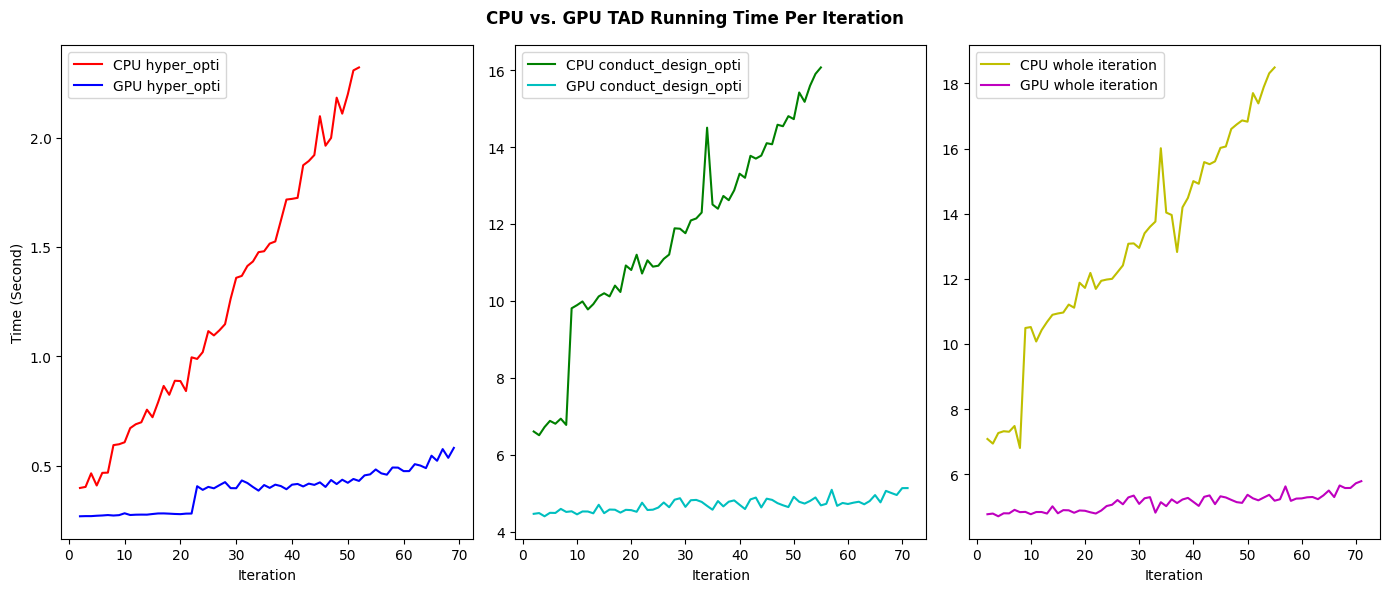

In [19]:
# Plotting CPU vs. GPU time

# # Initialize plots
plt.style.use('default')
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

plt.suptitle('CPU vs. GPU TAD Running Time Per Iteration', fontweight='bold')

ax1.plot(cpu_hyper_x[1:], cpu_hyper_opti[1:], 'r-', label='CPU hyper_opti')
ax1.plot(gpu_hyper_x[1:], gpu_hyper_opti[1:], 'b-', label='GPU hyper_opti')
ax1.legend()


plt.subplot(132)
ax2.plot(cpu_conduct_x[1:], cpu_conduct_design[1:], 'g-', label='CPU conduct_design_opti')
ax2.plot(gpu_conduct_x[1:], gpu_conduct_design[1:], 'c-', label='GPU conduct_design_opti')
ax2.legend()
# plt.ylabel('Time')
# plt.xlabel('Input Size')

plt.subplot(133)
ax3.plot(cpu_total_x[1:], cpu_total[1:], 'y-', label='CPU whole iteration')
ax3.plot(gpu_total_x[1:], gpu_total[1:], 'm-', label='GPU whole iteration')
ax3.legend()

plt.setp([ax1,ax2,ax3], xlabel='Iteration')
plt.setp(ax1, ylabel='Time (Second)')

plt.legend()
plt.tight_layout()

## Discussions
The above figure shows the running time for three different parts of TAD in each iteartion of the algorithm. From left to right, the first plot shows the time for hyper parameter optimization, the second for TAD design optimization, and the third for the whole iteration.

As we can see, GPU is giving a siginificant accleration compared to CPU. If we compare the 52-th iteration (the last iteration on CPU) so that CPU and GPU are handling the same number of data points, we see that on GPU TAD is more than 5 times faster for hyper paramters optimization, more than 3 times faster for TAD design optimization, and more than 3 times faster for the whole iteration.

Moreover, we notice that the TAD design optimization part (which corresponds to the middle plot) contributes to the majority (more than 85%) of the running time in each iteration. Hence, optimizing the code and/or algorithm for this part is the most important. However, if data size becomes much larger, we anticipate "the other parts" (the parts after hyperparameters optimization and TAD design optimization) to take a decent amount of time because of their extensive use of expensive operations like `torch.matmul, torch.det, and torch.log`, although they take a trivial amount of time in this experiment. Therefore, putting such operations in "the other parts" in parallel on different GPUs is also a major concern when the data size gets very large in the future.

In addition, espeicially in the second and the third plot, the GPU running time is almost constant (with some fluctuations since TAD is a probabilistic method). This probably signal that the amount of data in this experiment is still too small for the GPU to demonstrate its advantage. The same experiment with much larger data size and higher dimensions of input and output space can be very helpful. 

# Conclusions and Future Directions on Improving TAD Performance on GPU
Currently when TAD is running, the GPU usage is 22%, which is low (though not horribly low). In this scenario, simply changing to multiple GPUs without optimizing on a more atomic level won’t help in speed (unless we change to much higher dimensions or larger data size).

Finally, we suggest some future directions for improving the performance of TAD on GPU:
1. Enable multiple GPUs. This will be helpful if in the future TAD switches to much higher dimensions or makes use of much larger data size. To do so, first try to wrap the Kernel class with `MultiDeviceKernel` provided by GPytorch. Please visit the model definition cell of our `ConvSuccess_homoskedatic_SingleGPU.ipynb` and GPytorch example use of `MultiDeviceKernel` for for more details on this
2. As mentioned in the discussions part, operations like `torch.matmul, torch.det, and torch.log` can be costly when data size is large. Therefore, putting such operations from the parts after "hyperparameters optimization" and "TAD design optimization" of the TAD algorithm in parallel on different GPUs is also a major concern when the data size gets very large in the future. A lot of such operations are independent and can be computed in parallel. This can probably be realized with pytorch built-in GPU related functions.
3. To do GPU code optimization on a more atomic level, probably the easiest way is to use a library called `numba`. Yet it is still quite demanding and probably not worth it depending on the situation. Definitely consider the directions 1. and 2. first.
4. Use LOVE and KISS-GP in the GP Model

## TAD process visualization. Non-related to the numerical experiment. May ignore the following part.

# Plotting model validation strategy

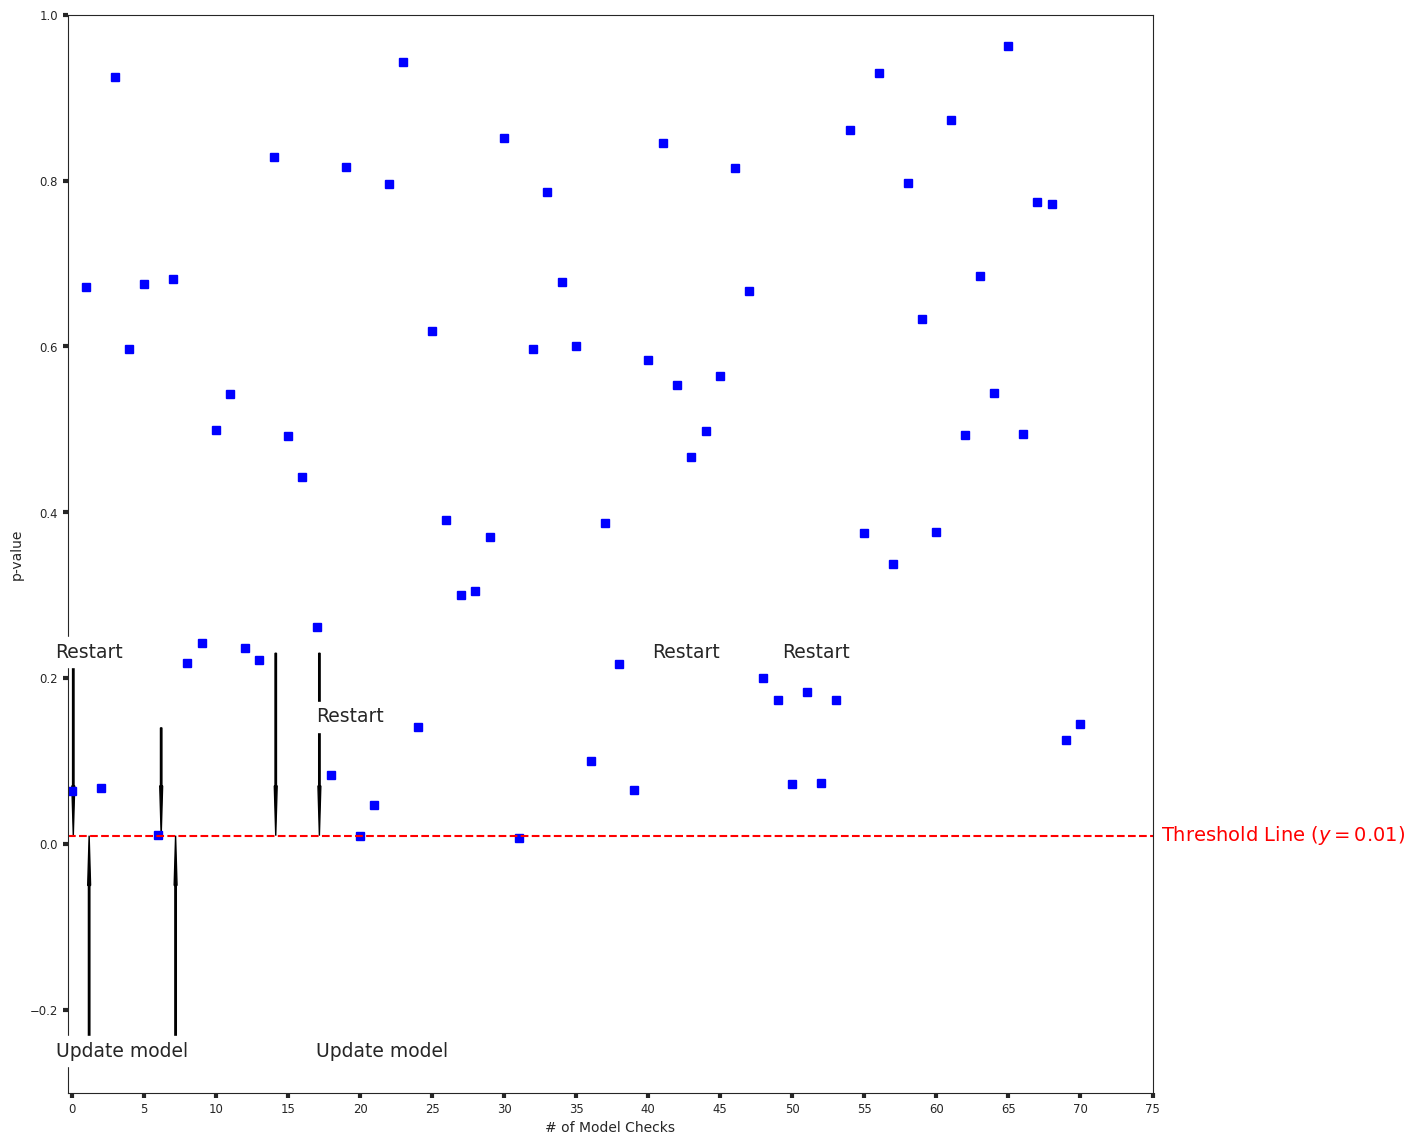

In [21]:
sns.set_style('ticks')
#plt.rcParams["pdf.use14corefonts"] = True
data_fit_vec_plot = 0.5* data_fit_vec.detach()[1:]
entropy_vec_plot = entropy_vec.detach()[1:]
p21_vec_plot = p21_vec.detach()[1:]
f, ax = plt.subplots(1, 1, figsize=(14, 14))
#ax.plot(np.array(range(2,iter+2)), torch.log(entropy_vec_plot), '+-')
#print(p21_vec_plot)
ax.plot(p21_vec_plot,'s',color = 'blue', markersize=6)
ax.axhline(.01,linestyle = '--',color = 'red', markersize=12, alpha = 1.0)
ax.set_xlim(-0.3, p21_vec_plot.shape[0])
ax.set_ylim(-0.3, 1.)
#ax.set_yscale('log')
plt.xticks(np.arange(0, iter+7, step=5.))
ax.tick_params(labelsize='small', width=3)
ax.set_xlabel('# of Model Checks')
ax.set_ylabel('p-value')
ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.05, 0.03), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(1.2,        #x start point
             -0.25,                      #y start point
             0,       #change in x 
             0.2,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black')             #arrow edge color

ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.02, 0.4), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(0.1,        #x start point
             0.23,                      #y start point
             0,       #change in x 
             -0.16,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 


############################
ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.26, 0.34), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(6.2,        #x start point
             0.14,                      #y start point
             0,       #change in x 
             -0.07,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 



ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.29, 0.03), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(7.2,        #x start point
             -0.25,                      #y start point
             0,       #change in x 
             0.2,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black')             #arrow edge color

############################
ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.57, 0.4), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(14.15,        #x start point
             0.23,                      #y start point
             0,       #change in x 
             -0.16,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 
################################


############################
ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.69, 0.4), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(17.18,        #x start point
             0.23,                      #y start point
             0,       #change in x 
             -0.16,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 
################################



# ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.32, 0.03), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(10.25,        #x start point
#              -0.25,                      #y start point
#              0,       #change in x 
#              0.2,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black')             #arrow edge color

# ############################

# ############################
# ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.33, 0.34), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(11.25,        #x start point
#              0.14,                      #y start point
#              0,       #change in x 
#              -0.07,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black') 
# #################################################

# ################################


# ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.38, 0.1), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(12.25,        #x start point
#              -0.15,                      #y start point
#              0,       #change in x 
#              0.1,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black')             #arrow edge color





################################




# ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.38, 0.4), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(13.25,        #x start point
#              0.23,                      #y start point
#              0,       #change in x 
#              -0.16,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black') 
# ################################


# ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.55, 0.03), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(18.25,        #x start point
#              -0.25,                      #y start point
#              0,       #change in x 
#              0.2,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black')  
# ################################




# ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.49, 0.4), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(17.25,        #x start point
#              0.23,                      #y start point
#              0,       #change in x 
#              -0.16,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black') 
# ################################

# ################################




# ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.55, 0.43), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(19.25,        #x start point
#              0.26,                      #y start point
#              0,       #change in x 
#              -0.19,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black') 
# ################################

# ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.94, 0.43), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(33.25,        #x start point
#              0.26,                      #y start point
#              0,       #change in x 
#              -0.19,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black') 
# ################################


# ################################

ax.annotate('Threshold Line ($y = 0.01$)', xy=(1.0,0.01), xytext=(6,0), color='red', 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")


#ax.legend(['p-value'], loc = 'upper left', fontsize = 30)
plt.savefig('figures_Carlo/qvalue_base.pdf',dpi=300, bbox_inches='tight')
plt.show()

# Putting the data back to CPU for plotting and analysis

In [22]:
if use_cuda:
    vec_x = vec_x.cpu()
    g_theta1 = g_theta1.cpu()
    g_theta2 = g_theta2.cpu()
    x_train, y_train = x_train.cpu(), y_train.cpu()
    loss = loss.cpu()
    pf1 = pf1.cpu()
    Qf1 = Qf1.cpu()
    Qf12 = Qf12.cpu()
    Q21 = Q21.cpu()
    data_fit_vec = data_fit_vec.cpu()
    entropy_vec = entropy_vec.cpu()

# Plotting expected value and data fit term

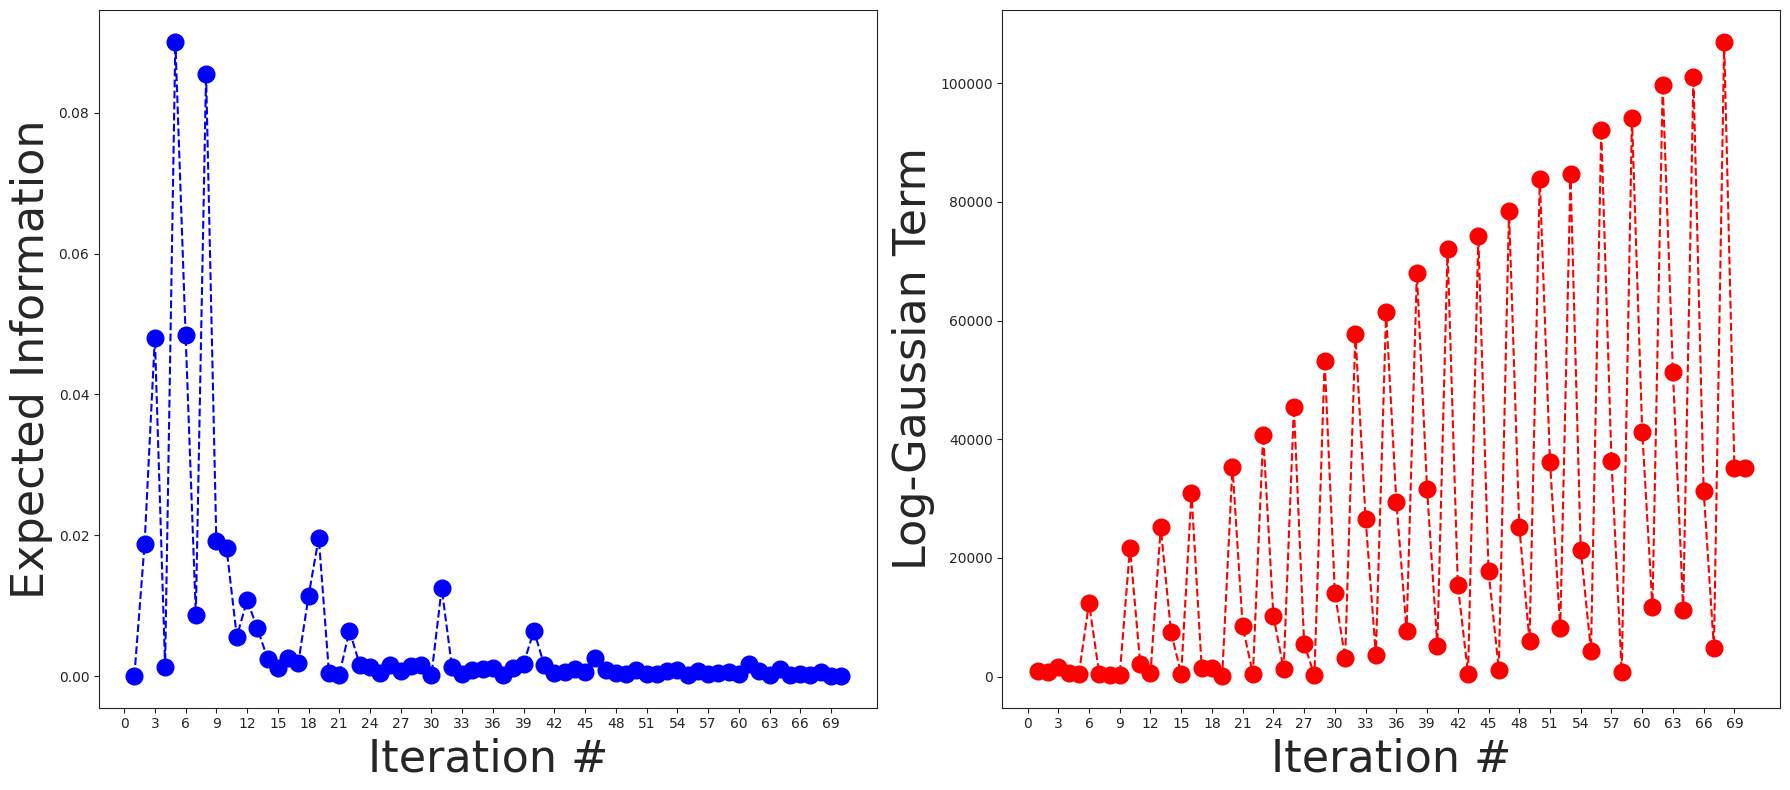

In [23]:
sns.set_style('ticks')
data_fit_vec_plot = 0.5* data_fit_vec.detach()[1:]
entropy_vec_plot = entropy_vec.detach()[1:]
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 8), tight_layout=True)

ax1.plot(np.array(range(1,iter+2)), (entropy_vec_plot), '--o', color = 'blue', markersize=12)
#ax1.set_yscale('log')
# ax.plot(np.array(data_fit_vec_plot), (entropy_vec_plot), 'o')
#ax1.set_yscale('log')

ax2.plot(np.array(range(1,iter+2)), data_fit_vec_plot, '--o', color = 'red', markersize=12)
#ax2.set_ylim(-10, 600)
ax1.set_xlabel('Iteration #', size=32)
ax2.set_xlabel('Iteration #', size=32)
ax1.set_ylabel('Expected Information', size = 32)
ax2.set_ylabel('Log-Gaussian Term', size = 32)
ax1.set_xticks(np.arange(0, iter+3, step=3.))
ax2.set_xticks(np.arange(0, iter+3, step=3.))
plt.savefig('figures_Carlo/exp_info/expectedinfo_vs_datafit_2_base.pdf',dpi=300, bbox_inches='tight')
plt.show()

# Saving all data needed for plots

In [24]:
np.savetxt('data_plots/vec_x_success_base.txt',vec_x.detach().numpy())
np.savetxt('data_plots/g_theta2_success_base.txt', g_theta2.detach().numpy())
np.savetxt('data_plots/g_theta1_success_base.txt', g_theta1.detach().numpy())
np.savetxt('data_plots/x_train_ini_success_base.txt', x_train.detach().numpy())
np.savetxt('data_plots/y_train_ini_success_base.txt', y_train.detach().numpy())
np.savetxt('data_plots/entropy_vec_success_base.txt', entropy_vec_plot.detach().numpy())
np.savetxt('data_plots/datafit_success_base.txt', data_fit_vec_plot.detach().numpy())
np.savetxt('data_plots/p21_vec_success_base.txt',p21_vec_plot.detach().numpy())
np.savetxt('data_plots/loss_success_base.txt',loss.detach().numpy())
np.savetxt('data_plots/pf1_success_base.txt',pf1.detach().numpy())
np.savetxt('data_plots/Qf1_success_base.txt',Qf1.evaluate().detach().numpy())
np.savetxt('data_plots/Qf12_success_base.txt', Qf12.evaluate().detach().numpy())
np.savetxt( 'data_plots/Q21_success_base.txt', Q21.evaluate().detach().numpy())
#np.savetxt('data_plots/iter_success.txt', iter+1)

In [25]:
v2 = g_theta2_vec.reshape(math.ceil(g_theta2_vec.shape[0]/2),2)
torch.save(v2, 'data_plots/v2_success_base.txt')

In [26]:
print(v2.shape)

torch.Size([213, 2])


# Plots for vizualization

/tmp/ipykernel_941184/2505842117.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "gd" (-> color='g'). The keyword argument will take precedence.
  ax.plot(0.8731, 0.5664,'gd', color = 'green',markersize=15)


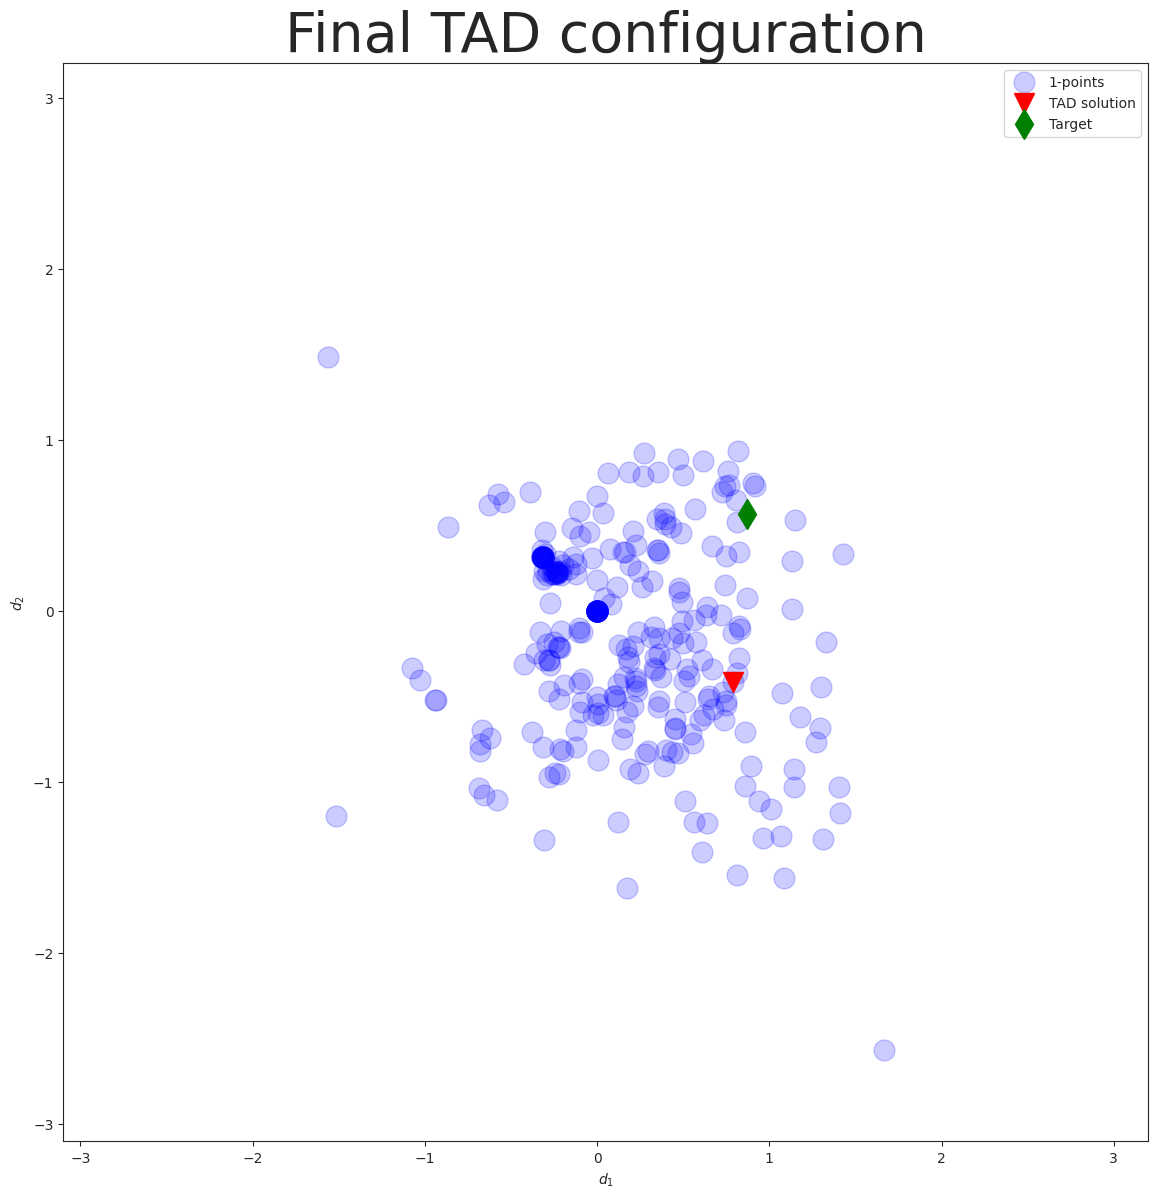

In [27]:
fig, ax = plt.subplots(figsize = (14,14))
ax.set_xlim(-3.1, 3.2)
ax.set_ylim(-3.1, 3.2)
#ax.scatter(g_theta1[:, 0].detach(),g_theta1[:, 1].detach(), c="b", alpha=0.8)
ax.plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'o', color = 'blue',markersize=15, alpha = 0.2)
ax.plot(vec_x[-1,0], vec_x[-1,1],'v', color = 'red',markersize=15)
ax.plot(0.8731, 0.5664,'gd', color = 'green',markersize=15)
ax.set_title('Final TAD configuration', fontsize = 40)
ax.set_xlabel('$d_1$')
ax.set_ylabel('$d_2$')
ax.legend(['1-points', 'TAD solution', 'Target'])
plt.savefig('figures_Carlo/strategies/tad_sol_all_2_base.pdf')
plt.show()

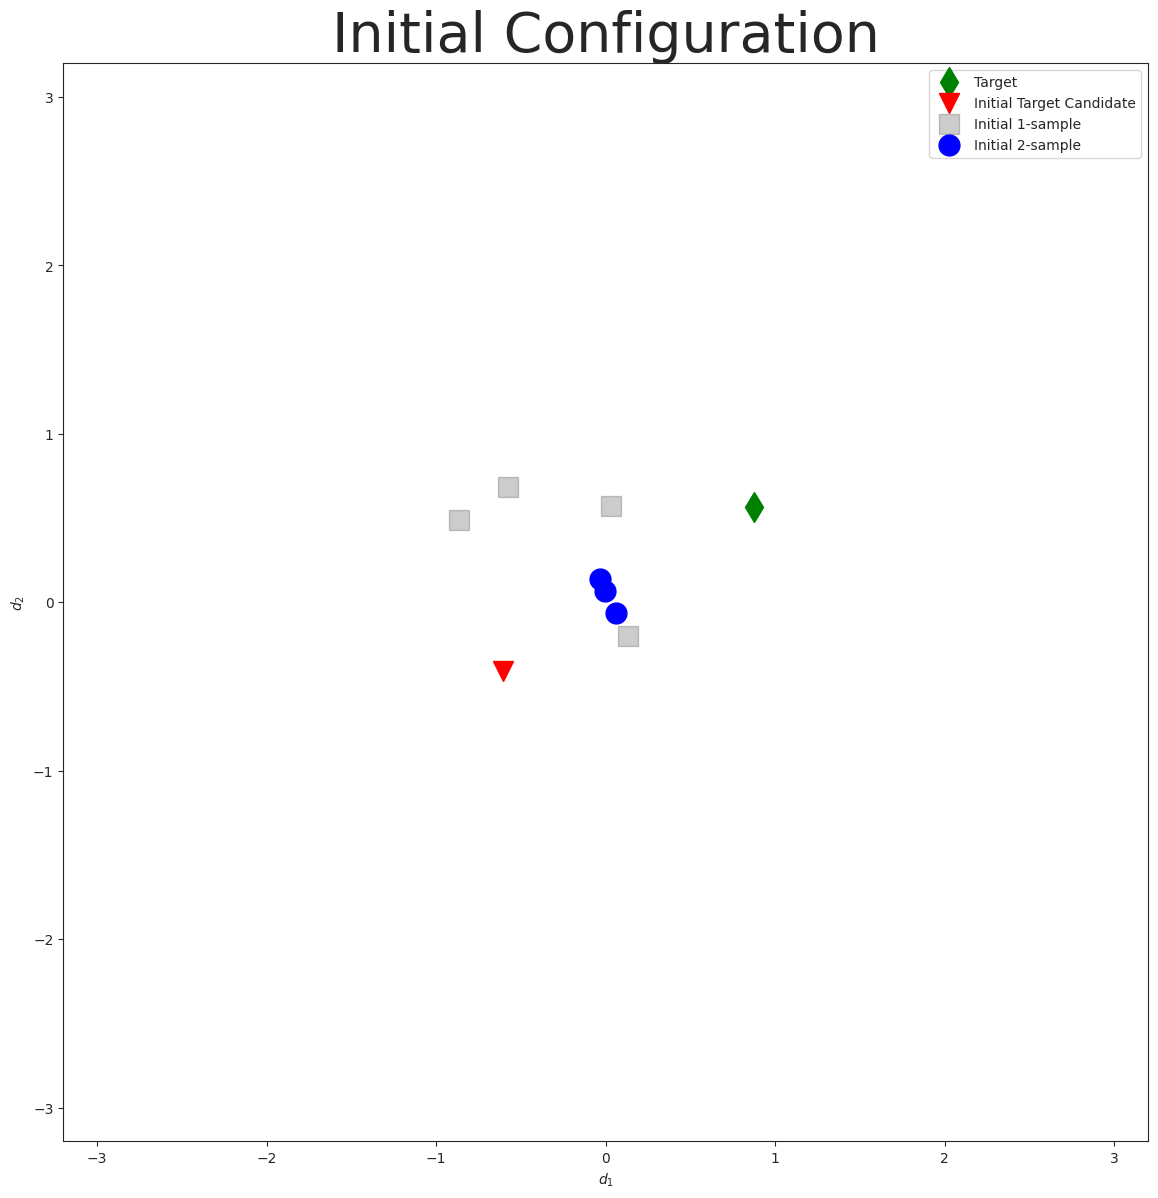

In [28]:
vec_x = vec_x.detach()
#v2 = g_theta2_vec.reshape(math.ceil(g_theta2_vec.shape[0]/2), 2)
ii = 0
low = -3.2
high = 3.2
v2 = v2.cpu()
########################
f, ax = plt.subplots(1, 1, figsize=(14, 14))
ax.plot(0.8731, 0.5664,'d', color = 'green',markersize=15)
ax.plot(vec_x[ii,0], vec_x[ii,1],'v', color = 'red',markersize=15)
ax.plot(x_train.detach()[:,0], x_train.detach()[:,1], 's', color = 'black', markersize=15, alpha = 0.2)
ax.plot(v2.detach()[ii:ii+loc_size+1,0], v2.detach()[ii:ii+loc_size+1,1], 'o', color = 'blue', markersize=15)
ax.set_xlabel('$d_1$')
ax.set_ylabel('$d_2$')
ax.set_title('Initial Configuration', fontsize = 40)
ax.legend(['Target', 'Initial Target Candidate', 'Initial 1-sample','Initial 2-sample'])

ax.set_xlim(low, high)
ax.set_ylim(low, high)
plt.savefig('figures_Carlo/evol_solTAD/evol_sol_ini_2_base.pdf')